In [9]:
# read nc output from WAOM 10km run

import xarray as xr
import glob

# import pandas as p
# import numpy as np
# import numpy.ma as ma
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib as mpl
# # mpl.use('Agg')
# import matplotlib.pyplot as plt
# import matplotlib.dates as dates
# from matplotlib.ticker import NullFormatter
# from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

# import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# from datetime import datetime, timedelta

# from netCDF4 import Dataset
# from netCDF4 import num2date, date2num
# from matplotlib.ticker import NullFormatter
# from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

# import gsw
# import cmocean

# import pyresample

# from dask.distributed import Client
# import logging
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
# print(client)

In [3]:
# fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'

### Define functions following https://raphaeldussin.medium.com/modern-python-tools-for-the-roms-ocean-model-bfca8642db01

In [10]:
def remove_all_small_variables(ds):
    """ remove all the variables that have less than 3 dimensions
    
        Parameters:
            ds (xarray.Dataset): ROMS dataset
    """
    for v in ds.variables:
        if v not in ['Cs_r', 'Cs_w', 'hc', 'Vtransform', 'ocean_time']:
            ds = ds.drop_vars(v) if len(ds[v].dims) < 3 else ds
    return ds

In [11]:
def select_interior(ds):
    """
    discard "exterior" u,v,rho-points to build a symetric grid
    
        Parameters:
            ds (xarray.Dataset): ROMS dataset
    """
    ds = ds.isel(xi_rho=slice(1,-1), eta_rho=slice(1,-1))
    if 'xi_v' in ds.dims:
        ds = ds.isel(xi_v=slice(1,-1))
    if 'eta_u' in ds.dims:
        ds = ds.isel(eta_u=slice(1,-1))
    return ds

In [12]:
def rename_dims(ds):
    """ rename dimensions
    
        Parameters:
            ds (xarray.Dataset): ROMS dataset
    
    """
    ds = ds.rename({'xi_rho': 'xh', 'xi_v': 'xh', 'xi_u': 'xq', 'xi_psi': 'xq',
                    'eta_rho': 'yh', 'eta_v': 'yq', 'eta_u': 'yh', 'eta_psi': 'yq',
                    'ocean_time': 'time'
                    })
    return ds

In [13]:
def add_coords(ds):
    """ set coordinate variables as xarray coordinates
    
        Parameters:
            ds (xarray.Dataset): ROMS dataset
    """
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform', 'time',
                        'lon_rho', 'lon_v', 'lon_u', 'lon_psi',
                        'lat_rho', 'lat_v', 'lat_u', 'lat_psi'])
    return ds


In [24]:
%%time

# use glob to create a list of files to convert
filelist = glob.glob('/g/data/gv90/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')
# path to grid file
gridfile = '/g/data/gv90/fbd581/ROMS/waom4_frc/waom4extend_grd.nc'
# output store name
store_name = '/g/data/gv90/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/WAOM4_store'

# load the grid
ds_grid = xr.open_dataset(gridfile)
                             
# select interior points for grid variables
ds_grid = select_interior(ds_grid)

first=True
# iterate on files
for ncfile in filelist:
    ds = xr.open_dataset(ncfile)
    ds = remove_all_small_variables(ds)
    ds = select_interior(ds)
    ds = xr.merge([ds, ds_grid])
    ds = rename_dims(ds)
    ds = add_coords(ds)
    ds = ds.chunk({'time': 1})
    print(f"working on {ncfile}")
    if first:
        ds.to_zarr(store_name, consolidated=True, mode='w')
    else:
        ds.to_zarr(store_name, consolidated=True, mode='a', append_dim='time')
    first=False

working on /g/data/gv90/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc
CPU times: user 1min 5s, sys: 1min 7s, total: 2min 12s
Wall time: 1min


#### report time:
Wall time: 19.8 s, WAOM10, 1yr file
Wall time: 13min 56s, WAOM10, 20yr files

In [21]:
ls /g/data/gv90/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr

11-20yr/            ocean_avg_0005.nc*   ocean_avg_0009.nc*
ocean_avg_0001.nc*  ocean_avg_0006.nc*   ocean_avg_0009.nc~*
ocean_avg_0002.nc*  ocean_avg_0007.nc*   ocean_avg_0010.nc*
ocean_avg_0003.nc*  ocean_avg_0008.nc*   ocean_avg_0010.nc~*
ocean_avg_0004.nc*  ocean_avg_0008.nc~*  tmp-3yrs/


### 2nd part: read Zarr and try some plots

In [26]:
def compute_depth_layers(ds, grid, hmin=0.1):
    """ compute depths of ROMS vertical levels (Vtransform = 2) """

    hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    
    # compute vertical transformation functional
    S_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    S_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    
    # compute depth of rho (layers) and w (interfaces) points
    z_rho = ds.zeta + (ds.zeta + hwater) * S_rho
    z_w = ds.zeta + (ds.zeta + hwater) * S_w
    
    # transpose arrays and fill NaNs with a minimal depth
    ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),
                                  transpose_coords=False).fillna(hmin)
    
    ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),
                                  transpose_coords=False).fillna(hmin)
    
    # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    
    # compute layer thickness as difference between interfaces
    ds['dz'] = grid.diff(ds['z_w'], 'Z')
    
    # add z_rho and z_w to xarray coordinates
    ds = ds.set_coords(['z_rho', 'z_w', 'z_v', 'z_u'])
    
    return ds


    #  New formulation (Vtransform(ng) = 2):
    #
    #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
    #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
    # hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    # Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    # z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 
    
    # Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    # z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 

In [28]:
from xgcm import Grid

WAOM4 = xr.open_zarr(store_name, consolidated=True)

# Create xgcm grid object
grid_waom4 = Grid(WAOM4, coords={'X': {'center': 'xh', 'outer': 'xq'},
                               'Y': {'center': 'yh', 'outer': 'yq'},
                               'Z': {'center': 's_rho', 'outer': 's_w'}},
                 periodic=False)

# Add depths of layers and interfaces to dataset
WAOM4 = compute_depth_layers(WAOM4, grid_waom4)



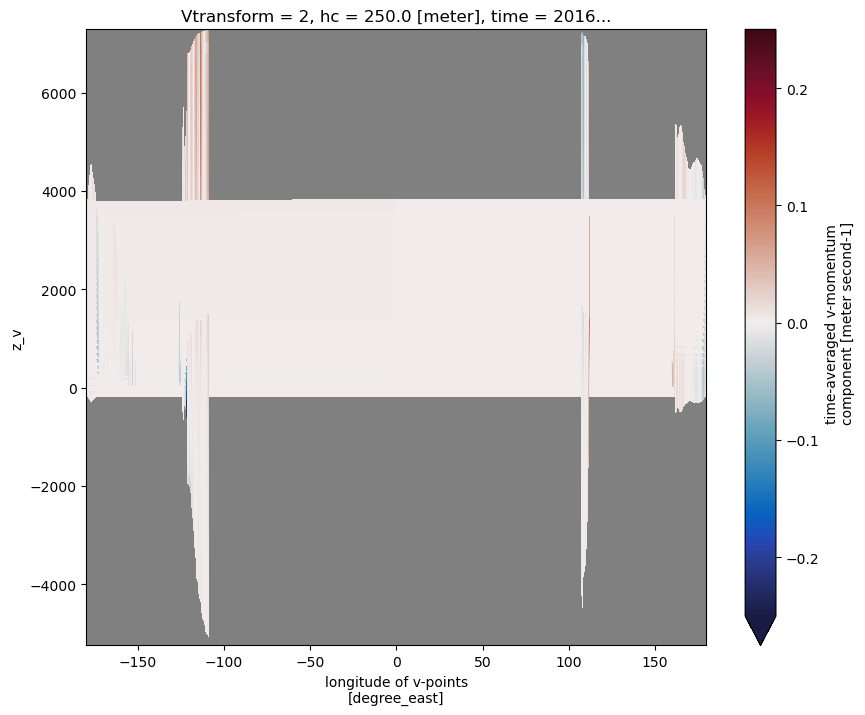

In [30]:
import matplotlib.pyplot as plt
import cmocean

plt.figure(figsize=[10,8])

WAOM4['v'].isel(time=11, yq=500).plot(x='lon_v', y='z_v',
                                     vmin=-0.25, vmax=0.25,
                                     cmap=cmocean.cm.balance,
                                     subplot_kws={'facecolor': 'grey'})